# EV Population & Policy Analysis  
**TT10L Transportation Project**  
**Author:** Your Name  
**Date:** 2025-06-XX  
**Dataset:** Electric_Vehicle_Population_Data.csv  
**Objectives:**  
1. Q1: CAFV eligibility by vehicle type & range  
2. Q2: Range performance by make/model  
3. Q3: Yearly trends in range & price  
4. Q4: Geographic & utility drivers in WA state  


### Imports & Settings

In [30]:
# core
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, r2_score



sns.set(style="whitegrid")

### Load & Inspect Data

In [31]:
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')
print(df.shape)
df.head()

(186879, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WBY8P6C58K,King,Seattle,WA,98115.0,2019,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,153,0,43.0,259254397,POINT (-122.3008235 47.6862671),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
1,5YJSA1DN4D,Kitsap,Bremerton,WA,98312.0,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,35.0,127420940,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,5.303508e+10
2,5YJSA1E26J,King,Kent,WA,98042.0,2018,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,249,0,47.0,170287183,POINT (-122.1145138 47.3581107),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
3,WBY2Z2C54E,King,Bellevue,WA,98004.0,2014,BMW,I8,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,41.0,205545868,POINT (-122.202397 47.619252),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
4,5YJXCDE23J,King,Bellevue,WA,98004.0,2018,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,41.0,237977386,POINT (-122.202397 47.619252),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10


In [32]:
df.info()
df.describe(include='all').T
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186879 entries, 0 to 186878
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         186879 non-null  object 
 1   County                                             186876 non-null  object 
 2   City                                               186876 non-null  object 
 3   State                                              186879 non-null  object 
 4   Postal Code                                        186876 non-null  float64
 5   Model Year                                         186879 non-null  int64  
 6   Make                                               186879 non-null  object 
 7   Model                                              186879 non-null  object 
 8   Electric Vehicle Type                              186879 non-null  object

VIN (1-10)                                             0
County                                                 3
City                                                   3
State                                                  0
Postal Code                                            3
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 403
DOL Vehicle ID                                         0
Vehicle Location                                       8
Electric Utility                                       3
2020 Census Tract                                      3
dtype: int64

### Cleaning & Feature Engineering

1.Drop columns with too many missing values,

2.Fill small‐count missing in location fields,

3.Convert dtypes & rename CAFV column,

4.Create any derived metrics

In [33]:
# 4.1 Drop high‐missing columns
df = df.drop(columns=['Legislative District'])  

# 4.2 Fill missing in location/text fields
for col in ['County','City','Electric Utility','2020 Census Tract']:
    df[col] = df[col].fillna('Unknown')

# Postal Code: fill with mode
mode_pc = df['Postal Code'].mode()[0]
df['Postal Code'] = df['Postal Code'].fillna(mode_pc)

# Vehicle Location: fill with 'Unknown' or leave as-is if not critical
df['Vehicle Location'] = df['Vehicle Location'].fillna('Unknown')

# 4.3 Convert numeric columns
df['Model Year']      = df['Model Year'].astype(int)
df['Electric Range']  = pd.to_numeric(df['Electric Range'], errors='coerce')
df['Base MSRP']       = pd.to_numeric(df['Base MSRP'], errors='coerce')

# 4.4 Rename CAFV column for ease
df = df.rename(columns={
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'CAFV_Eligibility'
})

# 4.5 Example derived metric: range per year of service
df['Range_per_Year'] = df['Electric Range'] / (2025 - df['Model Year'] + 1)

# Verify
print(df.dtypes)
print(df.isna().sum().loc[['Electric Range','Base MSRP']])

VIN (1-10)                object
County                    object
City                      object
State                     object
Postal Code              float64
Model Year                 int32
Make                      object
Model                     object
Electric Vehicle Type     object
CAFV_Eligibility          object
Electric Range             int64
Base MSRP                  int64
DOL Vehicle ID             int64
Vehicle Location          object
Electric Utility          object
2020 Census Tract         object
Range_per_Year           float64
dtype: object
Electric Range    0
Base MSRP         0
dtype: int64


## Q1 – Which electric vehicle types (BEV vs. PHEV) are more likely to receive CAFV eligibility status, and what factors influence that eligibility?

### Crosstab & Stacked Bar

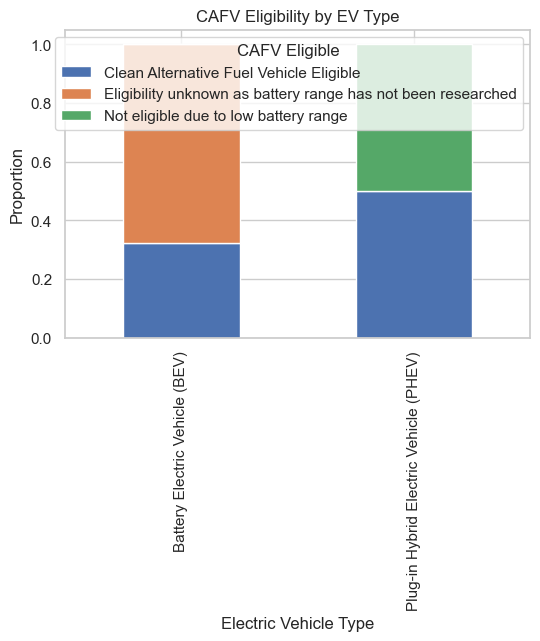

In [34]:
ct = pd.crosstab(
    df['Electric Vehicle Type'],
    df['CAFV_Eligibility'],
    normalize='index'
)
ct.plot(kind='bar', stacked=True, figsize=(6,4))
plt.ylabel('Proportion')
plt.title('CAFV Eligibility by EV Type')
plt.legend(title='CAFV Eligible')
plt.show()

Range Distribution Boxplot

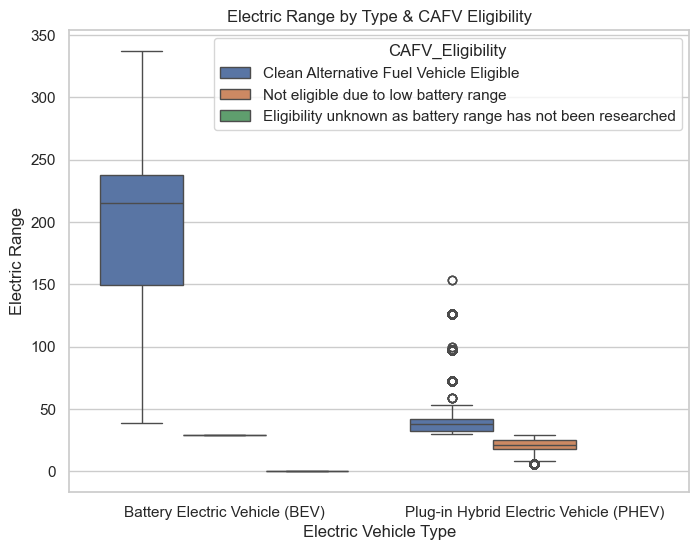

In [35]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x='Electric Vehicle Type',
    y='Electric Range',
    hue='CAFV_Eligibility'
)
plt.title('Electric Range by Type & CAFV Eligibility')
plt.show()


Optional: Logistic Regression

## Q2 – How does electric range vary by vehicle make and model, and which combinations provide the best performance?


(Columns: Make, Model, Electric Range)

In [36]:
top10 = (
    df.groupby(['Make','Model'])['Electric Range']
      .agg(['mean','count'])
      .query('count >= 5')
      .sort_values('mean', ascending=False)
      .head(10)
      .reset_index()
)
display(top10)


,Make,Model,mean,count
0,HYUNDAI,KONA,258.000000,224
1,TESLA,ROADSTER,234.583333,48
2,JAGUAR,I-PACE,203.741379,232
3,TESLA,MODEL S,174.770527,7831
4,CHEVROLET,BOLT EV,155.017857,7056
5,TESLA,MODEL X,132.596393,6043
6,AUDI,E-TRON,131.056744,1075
7,TESLA,MODEL 3,107.752100,30714
8,VOLKSWAGEN,E-GOLF,107.256267,1077
9,TOYOTA,RAV4,102.520000,50


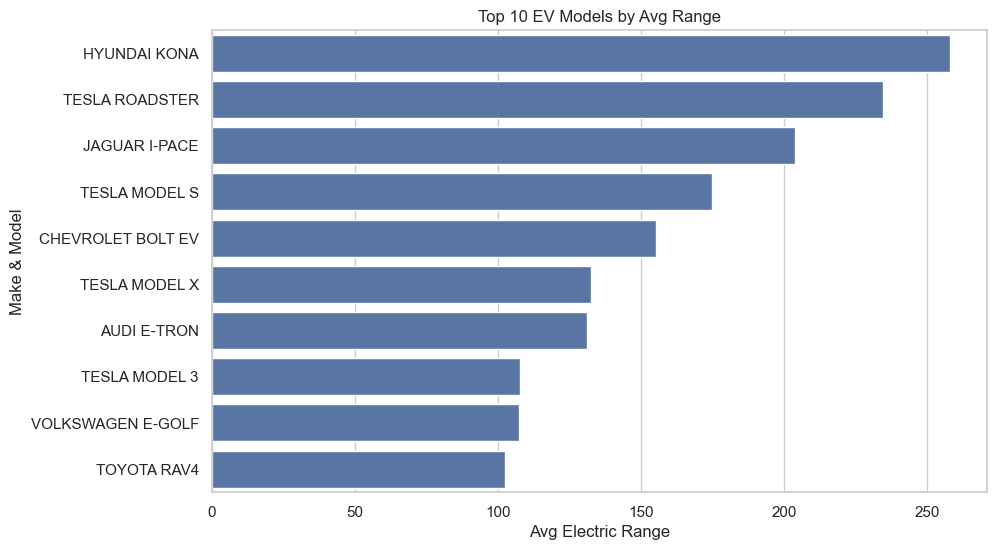

In [37]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='mean',
    y=top10['Make'] + ' ' + top10['Model'],
    data=top10
)
plt.xlabel('Avg Electric Range')
plt.ylabel('Make & Model')
plt.title('Top 10 EV Models by Avg Range')
plt.show()


## Q3 – Are there significant differences in EV registration by year, and do newer models offer better electric range or pricing tradeoffs?


(Columns: Model Year, Electric Range, Base MSRP)

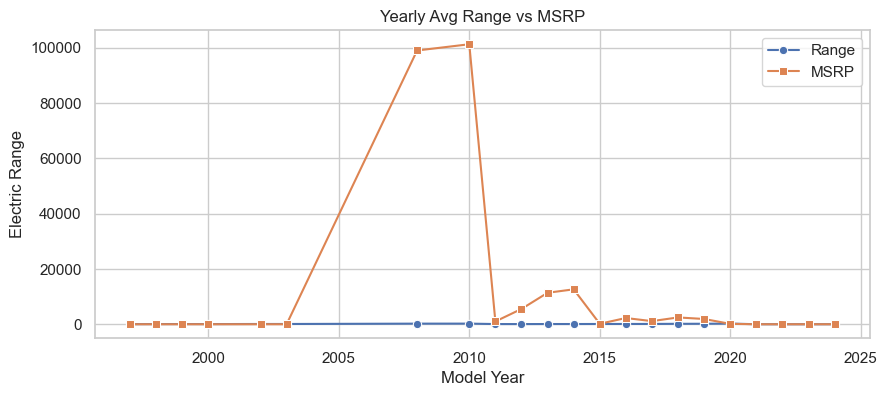

In [38]:
yearly = df.groupby('Model Year')[['Electric Range','Base MSRP']].mean().reset_index()

plt.figure(figsize=(10,4))
sns.lineplot(data=yearly, x='Model Year', y='Electric Range', marker='o', label='Range')
sns.lineplot(data=yearly, x='Model Year', y='Base MSRP',    marker='s', label='MSRP')
plt.title('Yearly Avg Range vs MSRP')
plt.legend()
plt.show()


## Q4 – Are there significant differences in the average base MSRP of EVs across different counties in Washington?

(Columns: Base MSRP, County)

In [43]:
# Clean the Base MSRP column: remove missing or zero values
df_price = df[(df['Base MSRP'].notna()) & (df['Base MSRP'] > 0)]

# Top 20 Counties by Average MSRP
avg_msrp_by_county = (
    df_price.groupby('County')['Base MSRP']
    .mean()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
print("\nTop 20 Counties by Average MSRP:")
print(avg_msrp_by_county)


Top 20 Counties by Average MSRP:
          County      Base MSRP
0        Charles  102000.000000
1      Multnomah   90700.000000
2   Spotsylvania   75095.000000
3      Albemarle   69900.000000
4       Columbia   69900.000000
5      Riverside   69900.000000
6         Collin   69900.000000
7      Klickitat   65383.333333
8         Yakima   64279.117647
9        Cowlitz   62685.000000
10        Chelan   62595.625000
11      Franklin   60263.571429
12     Wahkiakum   59931.666667
13        Travis   59900.000000
14         Mason   59675.652174
15       Douglas   59471.363636
16         Grant   58650.000000
17         Clark   58197.443182
18          King   57937.282930
19        Skagit   57430.454545


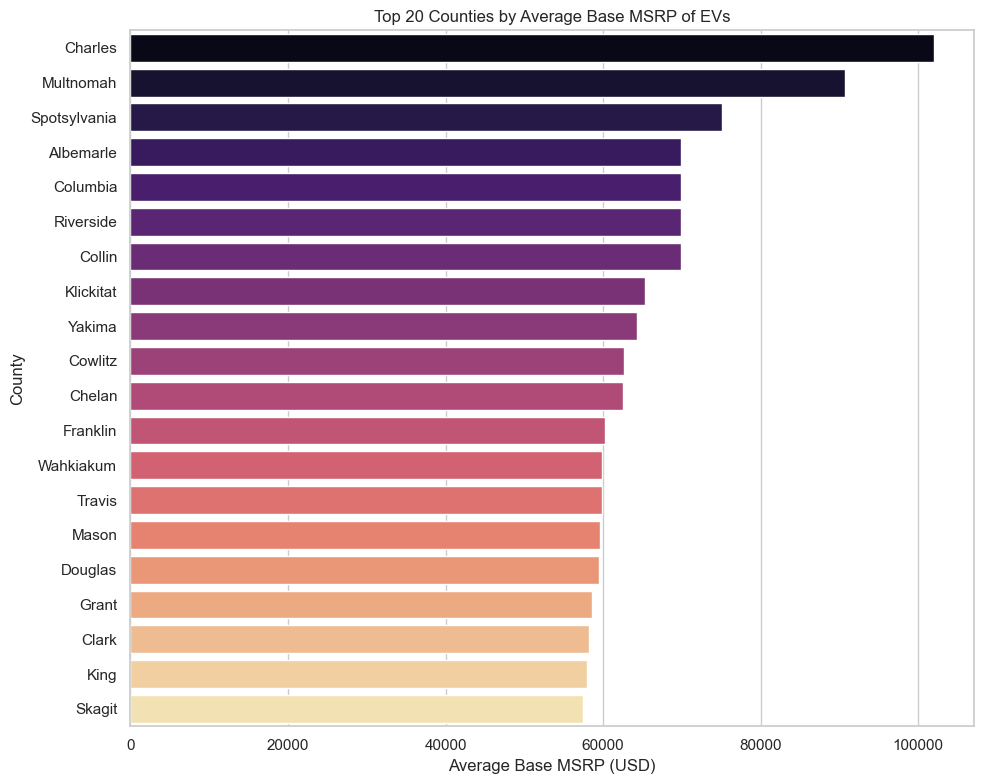

In [44]:
# Horizontal Bar Plot: Top 20 Counties by Average MSRP
plt.figure(figsize=(10, 8))
sns.barplot(
    data=avg_msrp_by_county,
    x='Base MSRP',
    y='County',
    hue='County',
    dodge=False,
    palette='magma',
    legend=False
)
plt.title('Top 20 Counties by Average Base MSRP of EVs')
plt.xlabel('Average Base MSRP (USD)')
plt.ylabel('County')
plt.tight_layout()